# Convert CST simulated hits in an x, y plane into a binned csv with the geometry of the HEL FC

In [2]:
#Imports as required. 
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#Happen to be the filenames I had from simulations. See Sameed about these files.
files = ['-10kV_0kV_5A_300A_600A_300A_anode_entrance.txt', '-10kV_0kV_5A_300A_600A_300A_anode_exit.txt', '-10kV_0kV_5A_300A_600A_300A_BPM_middle.txt', 
         '-10kV_0kV_5A_300A_600A_300A_BTV_BGC.txt', '-10kV_0kV_5A_300A_600A_300A_collector_electrode_entrance.txt', '-10kV_0kV_5A_300A_600A_300A_collector_main_pot_entrance.txt', 
         '-10kV_0kV_5A_300A_600A_300A_FC_YAG.txt']

filesout = ['anode_entrance', 'anode_exit', 'BPM_middle', 'BTV_BGC', 'collector_electrode_entrance', 'collector_main_pot_entrance', 'FC_YAG']

#The geometry of the FC.
(xs, ys) = ([-5, 5, -10, 0, 10, -5, 5], [8.66, 8.66, 0, 0, 0, -8.66, -8.66])
(xs, ys) = (np.divide(xs, 10), np.divide(ys, 10))

In [4]:
#Converting the files from the format given to me into one that plays nicer with pandas. Note Ive already standardised the second column name to just be 'anode_entrance' and removed the line of '----------'
for i in range(0,len(files)):
    with open(files[i]) as fin, open(filesout[i]+'.csv', 'w') as fout:
        o=csv.writer(fout)
        for line in fin:
            o.writerow(line.split())

In [5]:
#Lets read one and take a look.
index = 1
sim_df = pd.read_csv(filesout[index]+'.csv')
h = sim_df['upmm']
w = sim_df['anode_entrance']
sim_df

,upmm,anode_entrance
0,-8.619541,-1.795943
1,-8.618626,-1.803039
2,-8.549289,-1.798219
3,-8.513474,-0.564655
4,-8.507027,-1.855773
...,...,...
49511,8.495865,1.757726
49512,8.529677,1.765096
49513,8.546750,1.718785
49514,8.564581,1.779968


Seems normal, we have the x, y position of each hit. Lets plot the scatter of this:

<AxesSubplot:xlabel='upmm', ylabel='anode_entrance'>

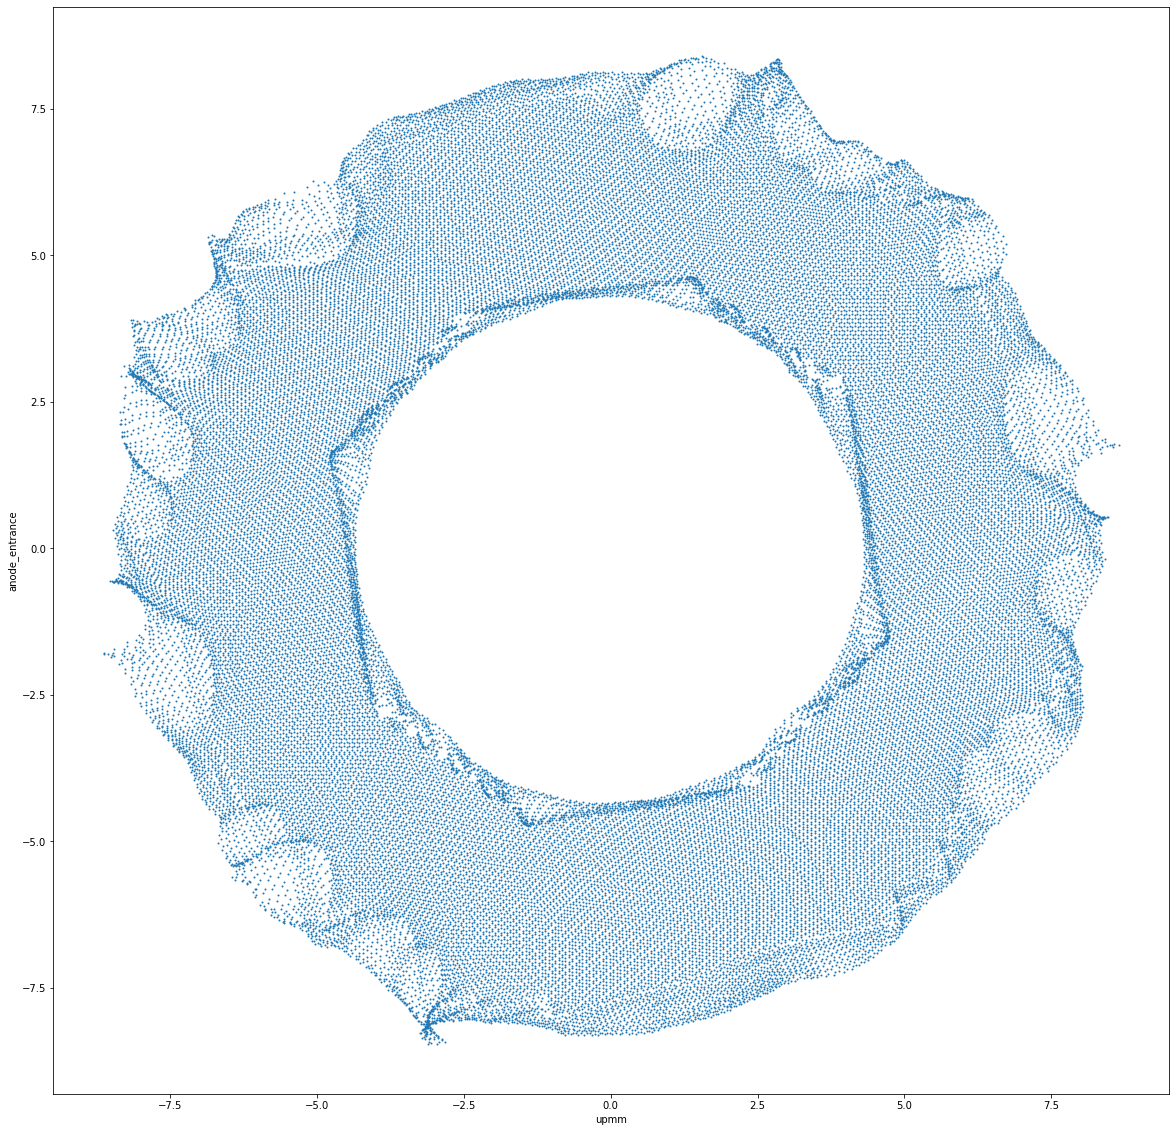

In [6]:
sim_df.plot.scatter(x='upmm',y='anode_entrance', s=1, figsize=(20, 20))

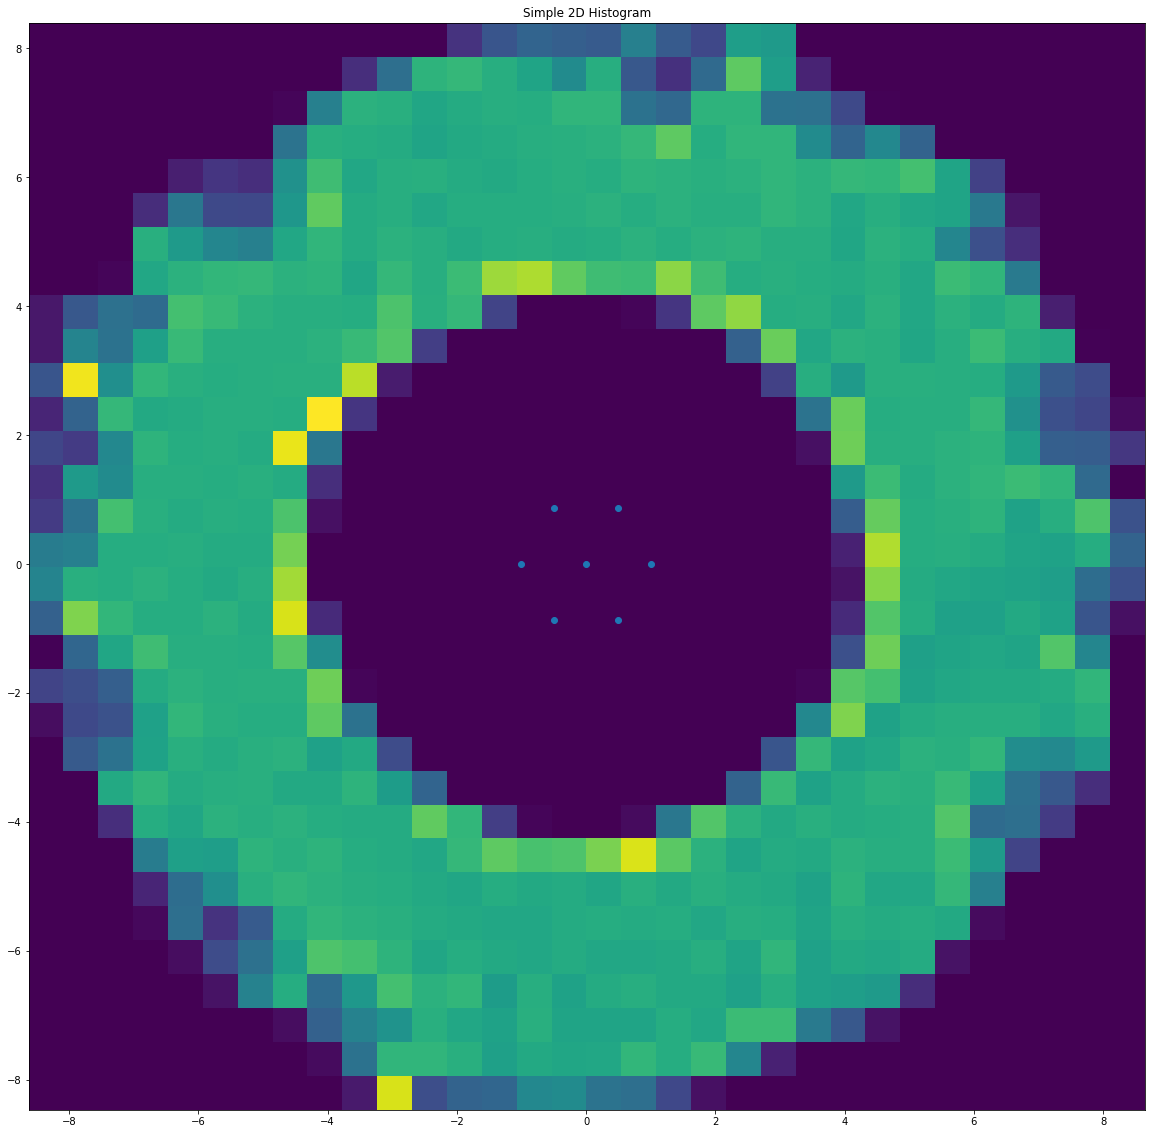

In [7]:
#And lets see how it looks binned. With the FC geometry on top.
#This is binned into square bins, whereas later we will bin into cups.
fig = plt.subplots(figsize =(20, 20))

plt.hist2d(h, w, 32)
plt.scatter(xs, ys)

plt.title("Simple 2D Histogram")
plt.show()

In [8]:
def inside_circle(x, y, x0, y0, r):
    """
    ===
    Function to tell you whether the point (x, y) is within the circle centered on (x0, y0) of radius r.
    ===
    :(x, y): Given point
    :(x0, y0): Center of circle
    :r: radius of circle centered on (x0, y0)
    :return: boolean
    ===""" 
    return (x - x0)*(x - x0) + (y - y0)*(y - y0) < r*r

In [9]:
w.max(), w.min(), h.min(), h.max()

(8.3986285, -8.4682171, -8.6195409, 8.646232)

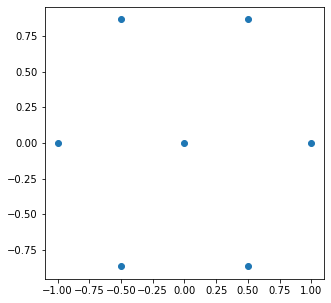

In [10]:
#Lets just look at the geometry of the FC.
(xs, ys) = ([-5, 5, -10, 0, 10, -5, 5], [8.66, 8.66, 0, 0, 0, -8.66, -8.66])
(xs, ys) = (np.divide(xs, 10), np.divide(ys, 10))
plt.figure(figsize  = (5,5))
plt.scatter(xs,ys)

In [11]:
def convert_simfile_to_FC(filename, output, radius, bins):
    """
    ===
    Function to convert the filename into binned circles format as required by the HELReconstruction file.
    This function is very slow and is quite possibly the worst way to do this. It literally loops over each hit FOR each grid point. But I cannot find a clever way to do it with hist2d,
    or by using dynamic 2d bin edges. If anyone looking at this in future finds a solution please contact lgolino@cern.ch.
    In any case, this should only be used very rarely to convert data between formats. Once it's done you can ignore this function again.
    ===
    :filename: input file. Must be comma delimited with 2 columns: x, y, position of each hit
    :output: name of output file to save results, can be anything
    :radius: radius of circle to bin your data into. For our simulations this is 0.05
    :bins: number of bins (circles) to bin the data in each direction. square this number for total number of bins
    :return: empty
    ==="""
    sim_df = pd.read_csv(filename)
    h = sim_df['upmm']
    w = sim_df['anode_entrance']
    (xs, ys) = ([-5, 5, -10, 0, 10, -5, 5], [8.66, 8.66, 0, 0, 0, -8.66, -8.66])
    (xs, ys) = (np.divide(xs, 10), np.divide(ys, 10))

    x_bins = np.linspace(-8, 8, bins)
    y_bins = np.linspace(-8, 8, bins)

    h = sim_df['upmm']
    w = sim_df['anode_entrance']

    all_currents = []

    with open(output+'.csv', 'w') as fout:
        o=csv.writer(fout)
        o.writerow(('x','y','I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7'))
        for j in range(0, len(x_bins)):
            for k in range(0, len(y_bins)):
                currents = [0,0,0,0,0,0,0]
                for l in range(0,len(xs)):
                    for i in range(0, len(h)):
                        if inside_circle(h[i], w[i], x_bins[j]+xs[l], y_bins[k]+ys[l], radius):
                            currents[l] = currents[l] + 1
                o.writerow((x_bins[j],y_bins[k],currents[0],currents[1],currents[2],currents[3],currents[4],currents[5],currents[6]))

So then lets convert our files.

In [79]:
%%time

#For our files lets convert into format required for HELReconstruction.
for filename in filesout:
    print(filename+'.csv')
    convert_simfile_to_FC(filename+'.csv', filename+'_cupped', 0.05, 12)

anode_entrance.csv
anode_exit.csv
BPM_middle.csv
BTV_BGC.csv
collector_electrode_entrance.csv
collector_main_pot_entrance.csv
FC_YAG.csv
CPU times: user 1h 48s, sys: 4.12 s, total: 1h 52s
Wall time: 1h 2min 14s


This took about 1hr to convert all 7 files (~7*45000 data points). This isn't ideal but not worth the time to optimise much in my opinion.

And below is the final format after conversion. It contains x, y, position of the center of the FC and the 7 charges (currently in hits just multiply by 0.01(?) to get absolute charge instead.

In [13]:
pd.read_csv('collector_electrode_entrance_cupped.csv.csv')

,x,y,I1,I2,I3,I4,I5,I6,I7
0,-8.0,-8.000000,0,0,0,0,0,0,0
1,-8.0,-6.545455,0,0,0,0,0,0,0
2,-8.0,-5.090909,0,0,0,0,0,0,0
3,-8.0,-3.636364,0,1,2,0,0,0,0
4,-8.0,-2.181818,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
139,8.0,2.181818,1,0,0,2,0,0,0
140,8.0,3.636364,0,1,0,0,0,0,1
141,8.0,5.090909,0,0,0,0,0,0,0
142,8.0,6.545455,0,0,0,0,0,0,1


L. GOLINO

lgolino@cern.ch

166064